Kaggle Dataset Diabetes, Hypertensionand Stroke Prediction:https://www.kaggle.com/datasets/prosperchuks/health-dataset/data

In [3]:
import os

# Tune TensorFlow CPU usage 
os.environ["OMP_NUM_THREADS"] = "18"
os.environ["TF_NUM_INTRAOP_THREADS"] = "16"
os.environ["TF_NUM_INTEROP_THREADS"] = "8"

In [4]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import time
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt


Used to shuffle the dataset so that the predictions are not unevely measured.

In [5]:
#Change these paths as needed
data_path = "diabetes_data.csv"
shuffled_data_path =  "shuffled_diabetes_data.csv"

In [6]:
# Load the dataset
df = pd.read_csv(data_path)

#Shuffle the dataframe
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

#Save the shuffled dataframe to a new CSV file
df_shuffled.to_csv(shuffled_data_path, index=False)

# Phase 1

Dataset shape: (70692, 18)
    Age  Sex  HighChol  CholCheck   BMI  Smoker  HeartDiseaseorAttack  \
0  10.0  0.0       1.0        1.0  23.0     1.0                   0.0   
1  13.0  0.0       0.0        1.0  33.0     1.0                   0.0   
2   8.0  1.0       1.0        1.0  27.0     1.0                   0.0   
3   7.0  1.0       1.0        1.0  29.0     1.0                   0.0   
4   6.0  1.0       0.0        1.0  47.0     0.0                   0.0   

   PhysActivity  Fruits  Veggies  HvyAlcoholConsump  GenHlth  MentHlth  \
0           1.0     0.0      1.0                0.0      4.0       0.0   
1           0.0     1.0      1.0                0.0      3.0       0.0   
2           1.0     1.0      1.0                0.0      2.0       0.0   
3           0.0     1.0      0.0                0.0      3.0       0.0   
4           1.0     1.0      1.0                0.0      4.0      30.0   

   PhysHlth  DiffWalk  Stroke  HighBP  Diabetes  
0       0.0       0.0     0.0     0.0  

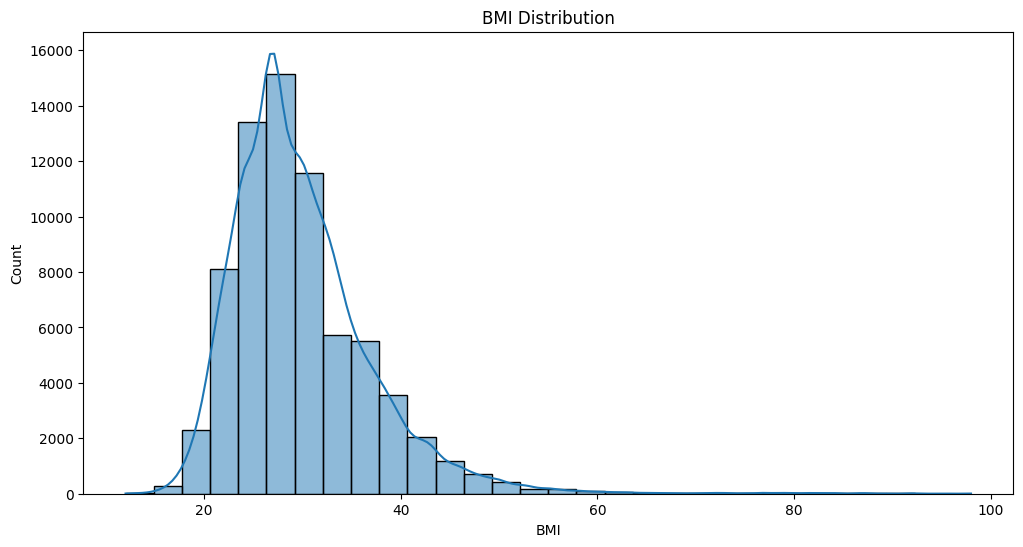

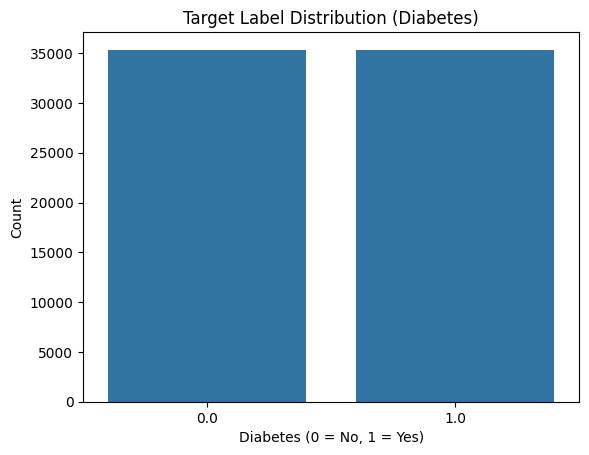

In [7]:

# Display dataset shape and first few rows
print("Dataset shape:", df_shuffled.shape)
print(df_shuffled.head())

# Check for null values
print("\nMissing values:")
print(df_shuffled.isnull().sum())

# Target column: Diabetes (0 or 1)
# Separate features and target
X = df_shuffled.drop(columns=['Diabetes'])
y = df_shuffled['Diabetes']

# Normalize numeric input features
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Split into training (90%) and validation (10%) sets
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.1, random_state=42, stratify=y)

# Print resulting shapes
print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

# Plot feature distribution examples
plt.figure(figsize=(12, 6))
sns.histplot(X['BMI'], kde=True, bins=30)
plt.title('BMI Distribution')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()

sns.countplot(x=y)
plt.title('Target Label Distribution (Diabetes)')
plt.xlabel('Diabetes (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()


# Phase 2

Overfitting the data

In [8]:
# Store results for Phase 2
overfitting_results = []

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True


In [9]:
def build_and_train_overfit_model(hidden_layers, neurons_per_layer, input_dim, epochs=1000, batch_size=256):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss=BinaryCrossentropy(),
                  metrics=['accuracy'])

    early_stop = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)

    history = model.fit(X_scaled, y, epochs=epochs, batch_size=batch_size, verbose=0, callbacks=[early_stop])

    final_acc = history.history['accuracy'][-1]
    return model, history, final_acc

In [10]:
# Testing model sizes
layer_sizes = [7]
neuron_options = [4096]

total_start_time = time.time()

for layers in layer_sizes:
    for neurons in neuron_options:
        print(f"Training model: {neurons} neurons x {layers} layers")
        start_time = time.time()
        model, history, final_acc = build_and_train_overfit_model(hidden_layers=layers, neurons_per_layer=neurons, input_dim=X_scaled.shape[1])
        end_time = time.time()
        elapsed_time = end_time - start_time
        overfitting_results.append((f"{neurons}-neurons x {layers}-layers", final_acc, elapsed_time))
        print(f"Finished model: {neurons}-neurons x {layers}-layers in {elapsed_time:.2f} seconds with final training accuracy: {final_acc:.4f}")
        if final_acc >= 0.99:
            break

total_end_time = time.time()

Training model: 4096 neurons x 7 layers


KeyboardInterrupt: 

In [ ]:
# Show Overfitting Results
print("\nOverfitting Results:")
labels = [str(config) for config, acc, elapsed_time in overfitting_results]
accuracies = [acc for config, acc, elapsed_time in overfitting_results]
times = [elapsed_time for config, acc, elapsed_time in overfitting_results]


Overfitting Results:


In [ ]:
for label, acc, elapsed in zip(labels, accuracies, times):
    print(f"{label} => Training Accuracy: {acc:.4f}, Time: {elapsed:.2f} seconds")

print(f"\nTotal training time for all models: {total_end_time - total_start_time:.2f} seconds")

8-neurons x 1-layers => Training Accuracy: 0.7506, Time: 67.35 seconds

Total training time for all models: 67.35 seconds


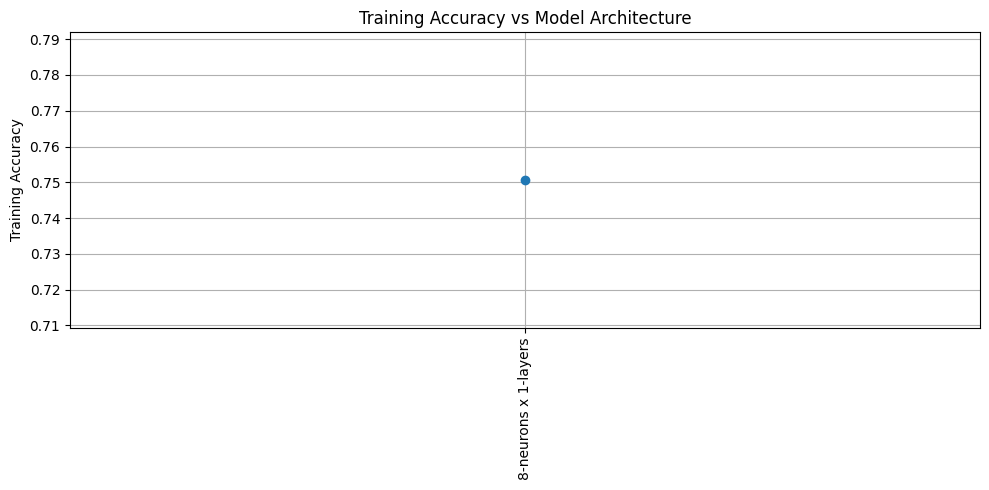

In [ ]:
# Plot Accuracy vs Model Configuration
plt.figure(figsize=(10, 5))
plt.plot(range(len(labels)), accuracies, marker='o')
plt.xticks(range(len(labels)), labels, rotation=90)
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy vs Model Architecture")
plt.grid(True)
plt.tight_layout()
plt.show()

# Phase 3: Model Selection and Evaluation

In [ ]:
# Store evaluation results
evaluation_results = []

# Custom EarlyStoppingByAccuracy callback
class EarlyStoppingByAccuracy(Callback):
    def __init__(self, monitor='accuracy', value=0.99):
        super().__init__()
        self.monitor = monitor
        self.value = value

    def on_epoch_end(self, epoch, logs=None):
        if logs.get(self.monitor) >= self.value:
            print(f"Reached {self.value*100:.1f}% training accuracy. Stopping training.")
            self.model.stop_training = True

# Function to build and train model for Phase 3
def train_and_evaluate_model_phase3(hidden_layers, neurons_per_layer, input_dim, model_name):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    for _ in range(hidden_layers):
        model.add(Dense(neurons_per_layer, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])

    checkpoint = ModelCheckpoint(f'{model_name}_best.keras', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStoppingByAccuracy(monitor='accuracy', value=0.99)

    history = model.fit(
        X_train, y_train,
        epochs=150,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint, early_stopping],
        verbose=0
    )

    preds = np.round(model.predict(X_val)).flatten()
    acc_train = history.history['accuracy'][-1]
    acc_val = accuracy_score(y_val, preds)
    loss_train = history.history['loss'][-1]
    loss_val = BinaryCrossentropy()(y_val, preds).numpy()
    precision = precision_score(y_val, preds)
    recall = recall_score(y_val, preds)
    f1 = f1_score(y_val, preds)
    params = model.count_params()

    evaluation_results.append((model_name, acc_train, acc_val, loss_train, loss_val, precision, recall, f1, params, history))


In [ ]:
# 1. Random Baseline Classifier
random_preds = np.random.choice([0, 1], size=y_val.shape)
random_acc = accuracy_score(y_val, random_preds)
random_precision = precision_score(y_val, random_preds)
random_recall = recall_score(y_val, random_preds)
random_f1 = f1_score(y_val, random_preds)
random_train_acc = accuracy_score(y_train, np.random.choice([0, 1], size=y_train.shape))
random_train_loss = 1.0
random_val_loss = 1.0

evaluation_results.append(("Random Baseline", random_train_acc, random_acc, random_train_loss, random_val_loss, random_precision, random_recall, random_f1, "-", None))


In [ ]:
# 2. Logistic Regression (no hidden layers)
train_and_evaluate_model_phase3(hidden_layers=0, neurons_per_layer=1, input_dim=X_train.shape[1], model_name="Logistic Regression")


In [ ]:
# 3. Neural Network Architectures to Evaluate
architectures = {
    "64-32-16-8-1": [64, 32, 16, 8],
    "32-16-8-1": [32, 16, 8],
    "16-8-1": [16, 8],
    "8-1": [8],
    "4-1": [4],
    "2-1": [2]
}

for name, layers in architectures.items():
    hidden_layers = len(layers)
    neurons_per_layer = layers[0]
    train_and_evaluate_model_phase3(hidden_layers, neurons_per_layer, X_train.shape[1], model_name=name)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 516us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 518us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step
221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 471us/step


In [ ]:
# Summarize Results
columns = ["Model", "Acc. on Training Set", "Acc. on Validation Set", "Loss on Training Set", "Loss on Validation Set", "Precision", "Recall", "F1 Score", "# Parameters", "History"]
results_df = pd.DataFrame(evaluation_results, columns=columns)


In [ ]:
# Display Table
print(results_df.drop(columns=['History']))


                 Model  Acc. on Training Set  Acc. on Validation Set  \
0      Random Baseline              0.496118                0.502546   
1  Logistic Regression              0.747697                0.744696   
2         64-32-16-8-1              0.786898                0.730552   
3            32-16-8-1              0.763447                0.739038   
4               16-8-1              0.755713                0.746393   
5                  8-1              0.750354                0.746818   
6                  4-1              0.750385                0.743423   
7                  2-1              0.750181                0.746676   

   Loss on Training Set  Loss on Validation Set  Precision    Recall  \
0              1.000000                1.000000   0.502511  0.509477   
1              0.513008                4.090710   0.734672  0.766054   
2              0.441945                4.316204   0.715267  0.766054   
3              0.484287                4.176583   0.707413  0.8

In [ ]:
# Identify Best Model
best_model = results_df.sort_values(by="Acc. on Validation Set", ascending=False).iloc[0]
print("\nBest Performing Model:")
print(best_model.drop(labels='History'))


Best Performing Model:
Model                          8-1
Acc. on Training Set      0.750354
Acc. on Validation Set    0.746818
Loss on Training Set      0.506141
Loss on Validation Set    4.053854
Precision                 0.722861
Recall                    0.800566
F1 Score                  0.759732
# Parameters                   153
Name: 5, dtype: object


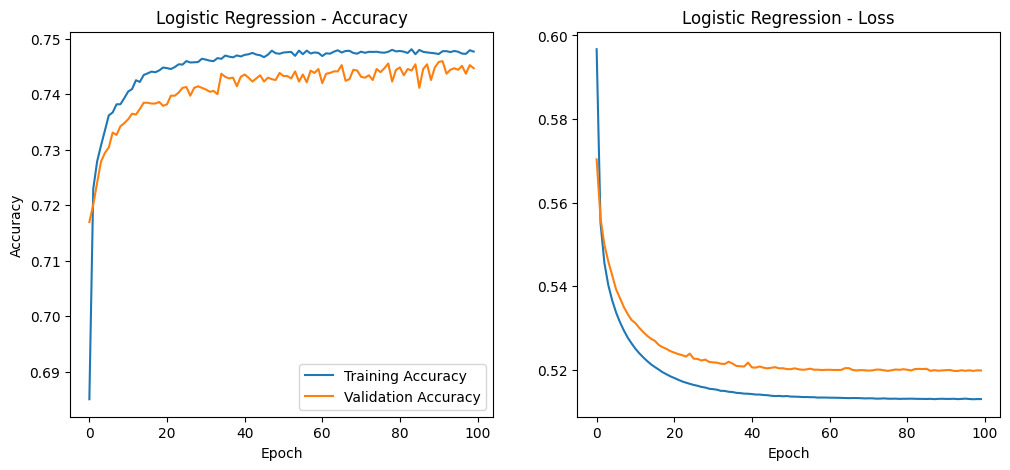

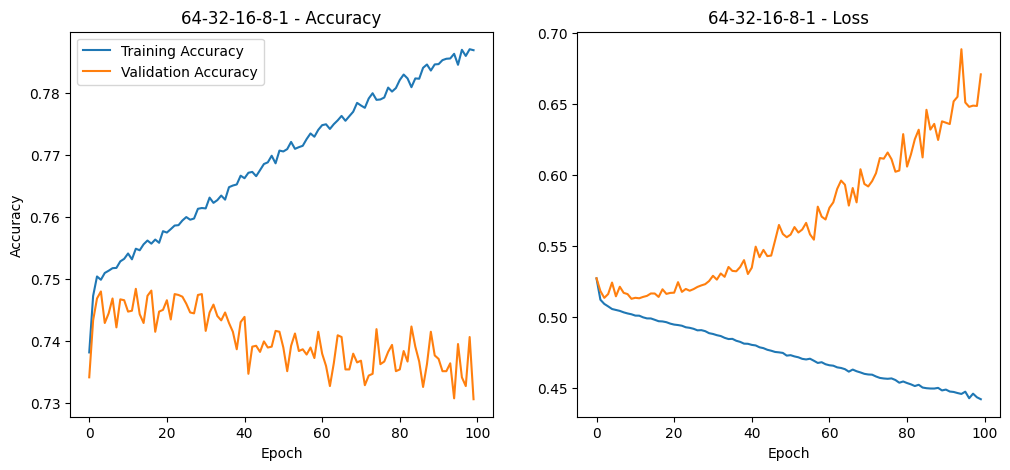

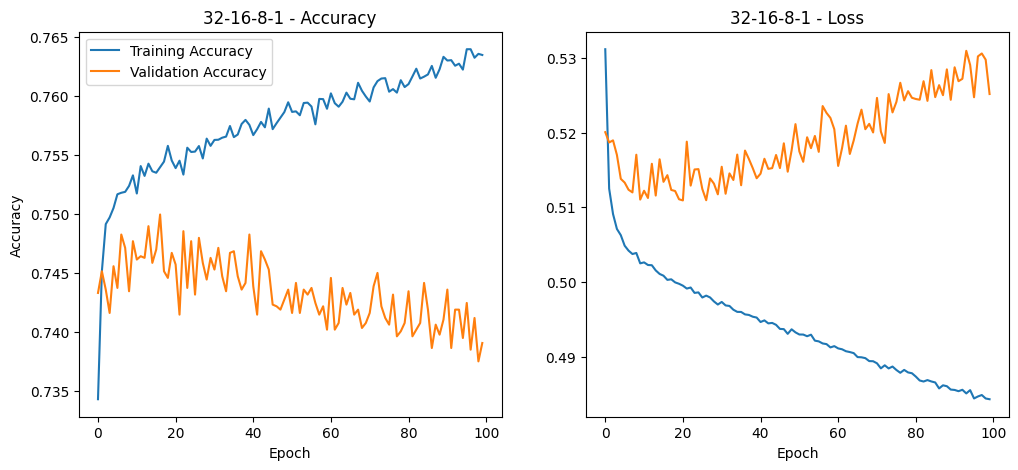

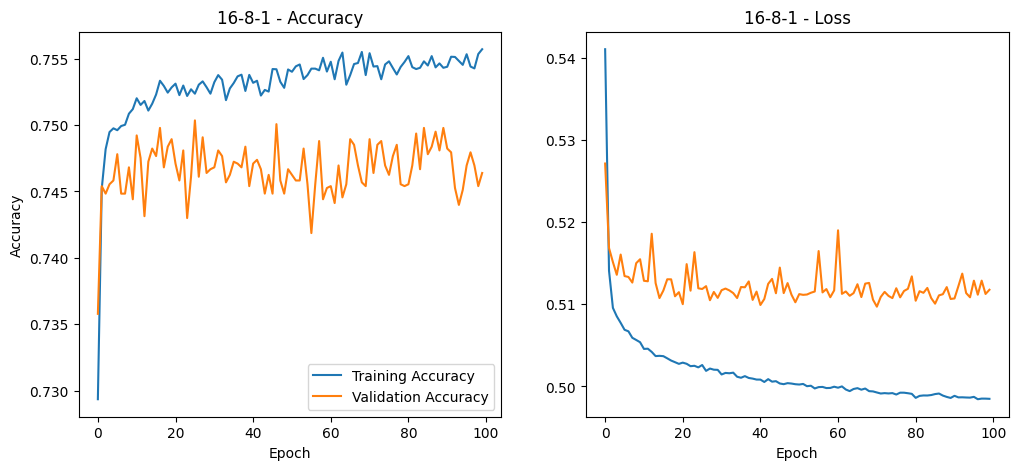

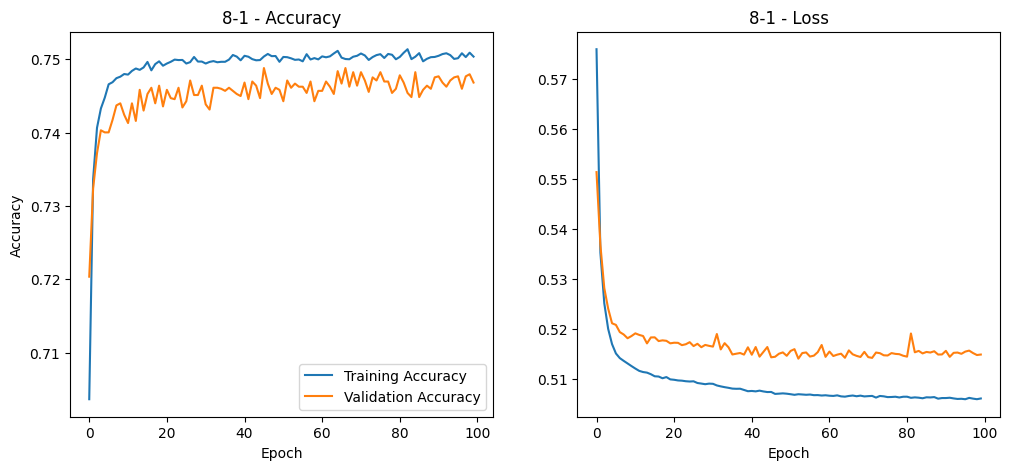

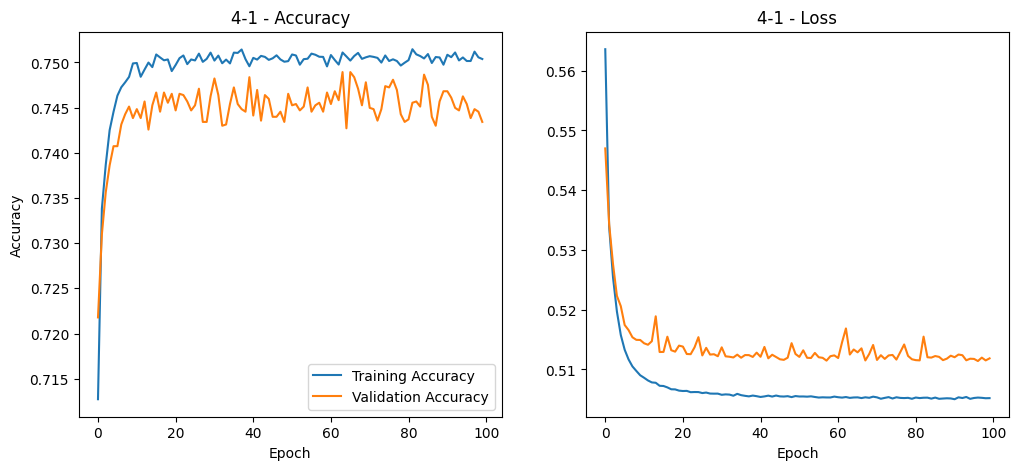

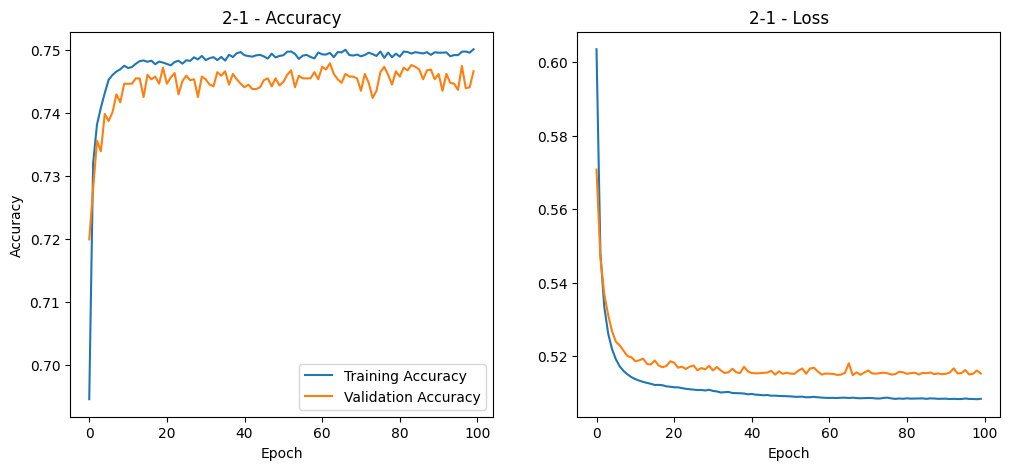

In [ ]:
# Plot Learning Curves for each model
for idx, row in results_df.iterrows():
    if row['History'] is not None:
        history = row['History']
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f"{row['Model']} - Accuracy")
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1,2,2)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{row['Model']} - Loss")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()